In [1]:
from functools import partial
from math import sqrt

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def modular_class(x, m):
    return x % m


def squared_modular_class(x, m):
    return (x**2) % m


def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


def get_q(x, P, rho):
    counts = th.bincount(x)
    _, order = th.sort(counts, descending=True)
    if P is None:
        P = len(counts)
    P = min(P, th.sum(counts!=0).item())
    idx = order[:P]
    q = (counts[idx] / counts[idx].sum())**rho
    return q, idx

In [3]:
# number of input tokens
n = 10
# number of output classes
m = 5
# memory dimension
# d = 50
d = 10

# number of data
t = 1000

# Zipf parameter
alpha = 1

In [4]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = modular_class(all_x, m)

# Embeddings
E = get_embeddings(n, d, norm=False)
U = get_embeddings(m, d, norm=True)

In [5]:
# Empirical data
x = th.multinomial(proba, t, replacement=True)
y = all_y[x]

In [6]:
P = None
rho = 0
q, idx = get_q(x[:t], P, rho)
W = (E[idx].T * q) @ U[all_y[idx]]
mat1 = E @ W @ U.T
mat1 = F.softmax(mat1, dim=-1)
mat1 = mat1.numpy()

rho = 1
q, idx = get_q(x[:t], P, rho)
W = (E[idx].T * q) @ U[all_y[idx]]
mat2 = E @ W @ U.T
mat2 = F.softmax(mat2, dim=-1)
mat2 = mat2.numpy()

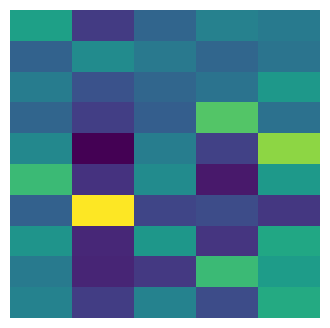

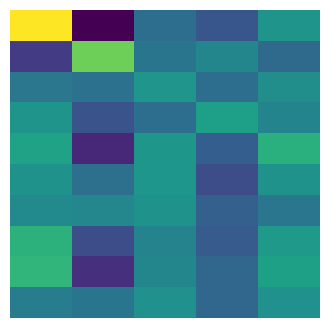

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
c = ax.imshow(mat1, aspect='auto')
ax.set_axis_off()
fig.savefig('fill_mat_d.pdf')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
c = ax.imshow(mat2, aspect='auto')
ax.set_axis_off()
fig.savefig('weight_mat_d.pdf')